In [1]:
#%matplotlib notebook
#from matplotlib import style
#style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Saving this here
# Measurement.__table__.columns.keys()

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

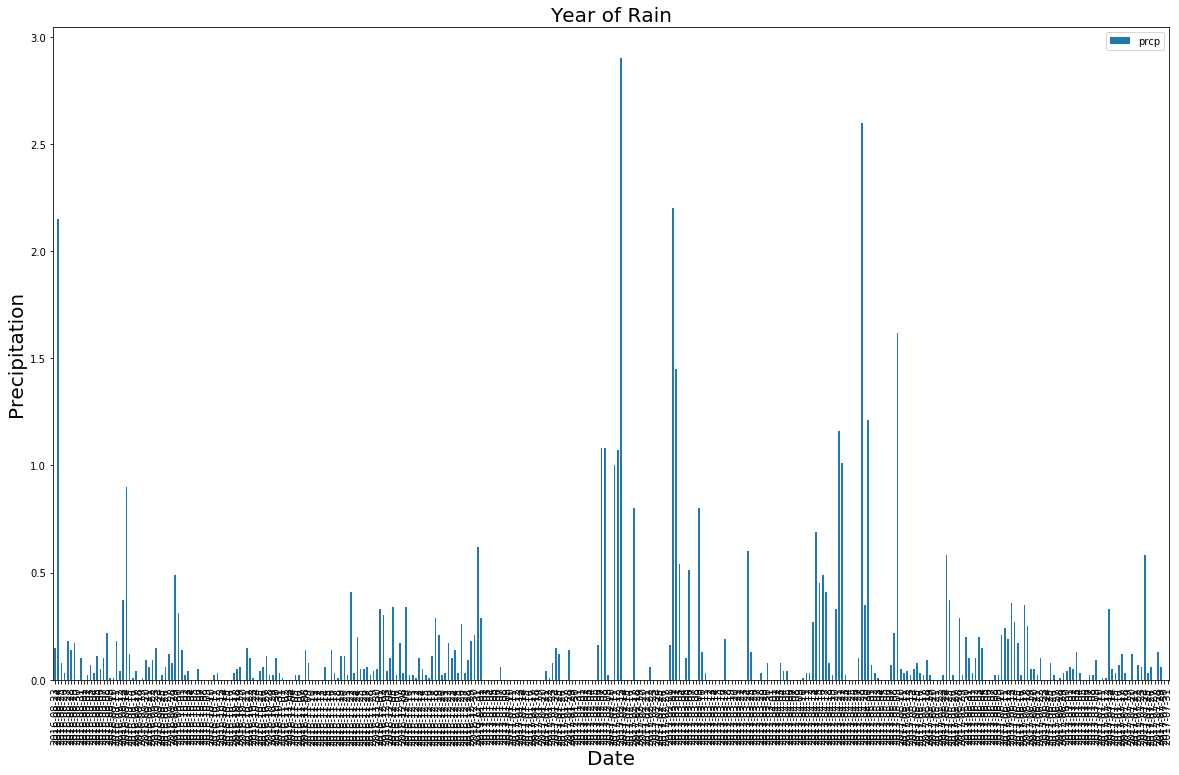

In [35]:
# Design a query to retrieve the last 12 months from 08-23-2017 of precipitation data and plot the results
# Calculate the date 1 year ago from today
today_not_today = dt.date(2017, 8, 23)
one_year_before_tnt = today_not_today - dt.timedelta(days=365)

########
# NOTE # Adding the station to the filter redueced the data points from 2021 to 343
########
# Perform a query to retrieve the data and precipitation scores
query_results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_before_tnt).\
    filter(Measurement.date <= today_not_today).filter(Measurement.station == 'USC00513117').all()

# Save the query results as a Pandas DataFrame and set the index to the date column
year_of_rain_df = pd.DataFrame(query_results)
year_of_rain_df.set_index('date', inplace=True)

# Sort the dataframe by date
year_of_rain_df.sort_index(ascending=True, inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
year_of_rain_df.plot.bar(rot=90)

plt.xlabel("Date", fontsize = 20)
plt.ylabel("Precipitation", fontsize = 20)
plt.title('Year of Rain', fontsize = 20)

plt.rcParams['figure.figsize'] = (20,12)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=20)

# Rotate the xticks for the dates
# See the rot=90 added to plot command above

In [11]:
# Show plot
plt.show()

In [34]:
# Use Pandas to calcualte the summary statistics for the precipitation data
year_of_rain_df.describe()

,prcp
count,343.000000
mean,0.141429
std,0.341245
min,0.000000
25%,0.000000
50%,0.030000
75%,0.120000
max,2.900000


In [13]:
# How many stations are available in this dataset?
rows = session.query(Station).count()
print(f'Total stations = {rows}')

Total stations = 9


In [36]:
# What are the most active stations?
# List the stations and the counts in descending order.

# Get station IDs
stations = engine.execute('SELECT station FROM station').fetchall()

station_freq = []
for station in stations:
    station_count = session.query(Measurement.station).filter(Measurement.station == station[0]).count()
    station_freq.append((station[0], station_count))

station_freq.sort(key=lambda x: x[1], reverse=True)
# So they are listed in a column
for station in station_freq:
    print(f'{station}')

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temps_from_station = session.query(Measurement.tobs).filter(Measurement.station == station_freq[0][0]).all()

# Sort the returned temps and get high/low values
temps_from_station.sort()
lowest_temp = temps_from_station[0]
highest_temp = temps_from_station[len(temps_from_station) - 1]

# Get average temp for the station with the most measurements
temp_total = 0
for temps in temps_from_station:
    temp_total = temp_total + temps[0]
average_temp = temp_total/(len(temps_from_station))
temp_results = [lowest_temp, highest_temp, average_temp]
print(temp_results)

[(54.0,), (85.0,), 71.66378066378067]


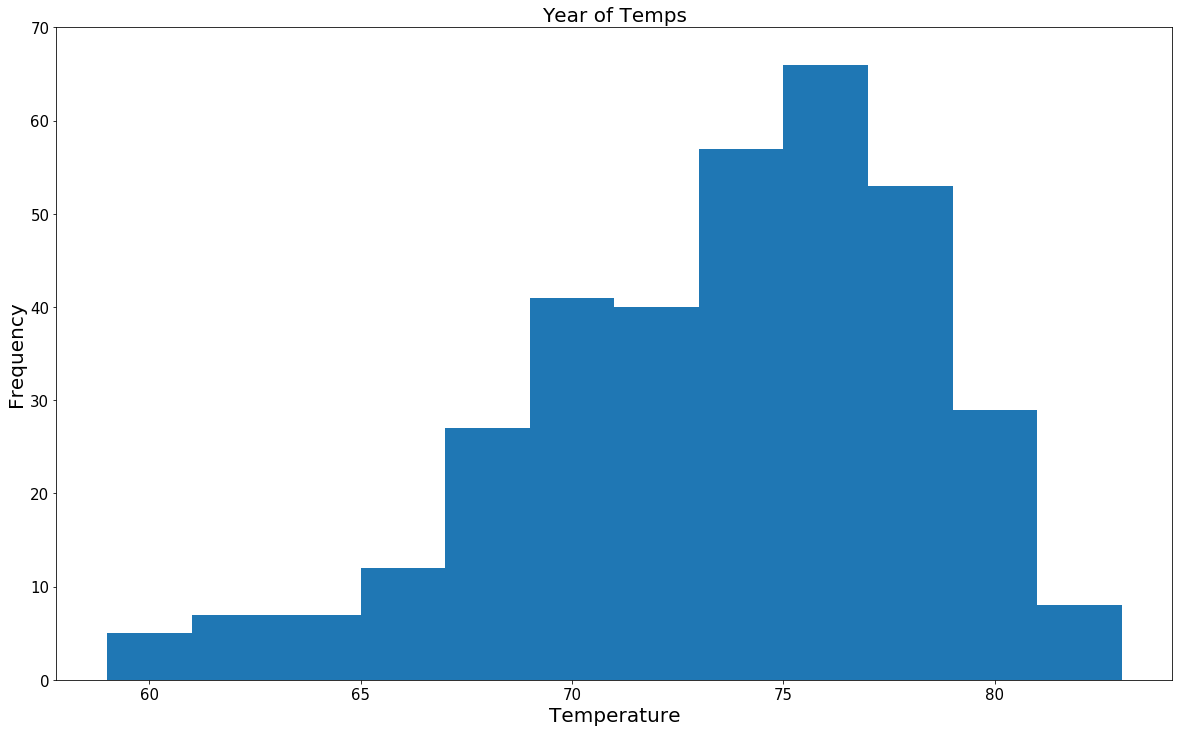

In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps_from_station_12m = session.query(Measurement.tobs).filter((Measurement.date >= one_year_before_tnt) & \
                                                            (Measurement.date <= today_not_today) & \
                                                            (Measurement.station == station_freq[0][0])).all()

temps_from_station_12m.sort()
lowest_temp_12m = temps_from_station_12m[0]
highest_temp_12m = temps_from_station_12m[len(temps_from_station_12m) - 1]

temps_array = np.asarray(temps_from_station_12m, dtype = float)

plt.hist(temps_array, bins=12)

plt.xlabel("Temperature", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.yticks(np.arange(0, 80, step=10))
plt.title('Year of Temps', fontsize=20)
plt.show()


In [17]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps(one_year_before_tnt, today_not_today)

[(58.0, 74.59058295964125, 87.0)]

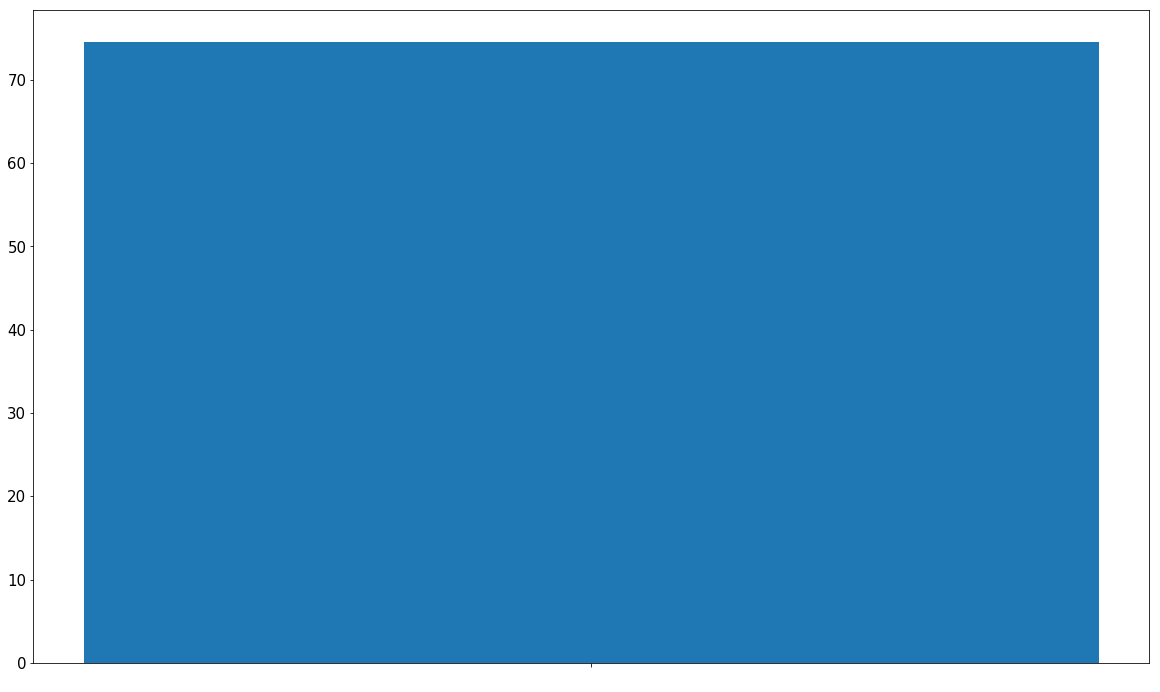

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
calc_temp_results = calc_temps(one_year_before_tnt, today_not_today)
ltemp = calc_temp_results[0][0]
atemp = calc_temp_results[0][1]
htemp = calc_temp_results[0][2]

x_axis = [" "]
temp_handle = plt.bar(x_axis, atemp, width=0.5)

plt.rcParams['figure.figsize'] = (20, 12)


In [20]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [24]:
# Plot the daily normals as an area plot with `stacked=False`
